In [1]:
import sys
sys.path.append("..")
from sklearn.datasets import load_wine
from deep_svdd import BaseSVDD
import os
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import glob
import cv2
from keras import layers
from sklearn.model_selection import train_test_split
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse
from keras import backend as K
from keras import models
param = 2**(-4)

In [2]:
X_list = glob.glob('bottle/train/good/*.png')
Y_list1 = glob.glob('bottle/test/broken_large/*.png')
Y_list2 = glob.glob('bottle/test/broken_small/*.png')
Y_list3 = glob.glob('bottle/test/contamination/*.png')
Y_list4 = glob.glob('bottle/test/good/*.png')
X_train = None
X_test_good = None
X_test_error = None
for X_file in X_list:
  im = cv2.imread(X_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_train is not None:
    X_train = np.concatenate((X_train, im))
  if X_train is None:
    X_train = im

for Y_file in Y_list1:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list2:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list3:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list4:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_good is not None:
    X_test_good = np.concatenate((X_test_good, im))
  if X_test_good is None:
    X_test_good = im

X_train = X_train/255
X_test_good = X_test_good/255
X_test_error = X_test_error/255
x_train, x_test = train_test_split(X_train, test_size=0.2)

In [3]:
image_size = X_train.shape[1] 
original_dim = image_size * image_size * 3
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train = np.reshape(X_train, [-1, original_dim])
X_train = X_train.astype('float32') / 255

X_test_good = np.reshape(X_test_good, [-1, original_dim])
X_test_good = X_test_good.astype('float32') / 255

X_test_error = np.reshape(X_test_error, [-1, original_dim])
X_test_error = X_test_error.astype('float32') / 255

input_shape = (original_dim, )
latent_dim = 20

In [4]:
# Reparametrization Trick 
def sampling(args):
    z_mean, z_logvar = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), seed = 5) # ε
    return z_mean + K.exp(0.5 * z_logvar) * epsilon

# VAEモデル構築
inputs = Input(shape=input_shape)
x1 = Dense(256, activation='relu')(inputs)  
x2 = Dense(64, activation='relu')(x1) 
z_mean = Dense(latent_dim)(x2)
z_logvar = Dense(latent_dim)(x2)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_logvar])
encoder = Model(inputs, [z_mean, z_logvar, z], name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,))
x3 = Dense(64, activation='relu')(latent_inputs)  
x4 = Dense(256, activation='relu')(x3)  
outputs = Dense(original_dim, activation='sigmoid')(x4)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

z_output = encoder(inputs)[2]
outputs = decoder(z_output)
vae = Model(inputs, outputs, name='variational_autoencoder')

# 損失関数
# Kullback-Leibler Loss
kl_loss = 1 + z_logvar - K.square(z_mean) - K.exp(z_logvar)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
# Reconstruction Loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(x_train,
                epochs=50,
                batch_size=64,
                validation_data=(x_test, None))

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 196608)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          50331904    ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           16448       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 20)           1300        ['dense_1[0][0]']                
                                                                                            

In [5]:
# _, _, x_tr = encoder.predict(X_train)
# _, _, x_tg = encoder.predict(X_test_good)
# _, _, x_te = encoder.predict(X_test_error)

x_tr, _, _ = encoder.predict(X_train)
x_tg, _, _ = encoder.predict(X_test_good)
x_te, _, _ = encoder.predict(X_test_error)

2/2 [==============================] - 0s 63ms/step




*** Fitting of the SVDD model is completed. ***

running time         = 0.1310 seconds
kernel function      = rbf
iterations           = 12
number of samples    = 209
number of features   = 20
number of SVs        = 17
ratio of SVs         = 8.1340 %
accuracy             = 96.1722 %




*** Prediction of the provided data is completed. ***

running time         = 0.0156 seconds
number of samples    = 209
number of alarm      = 8




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 20
number of alarm      = 2




*** Prediction of the provided data is completed. ***

running time         = 0.0065 seconds
number of samples    = 63
number of alarm      = 11




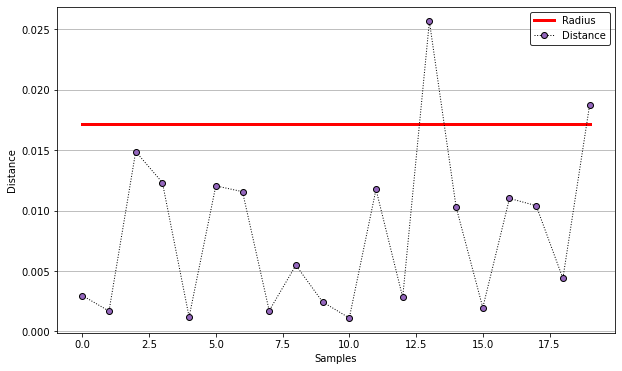

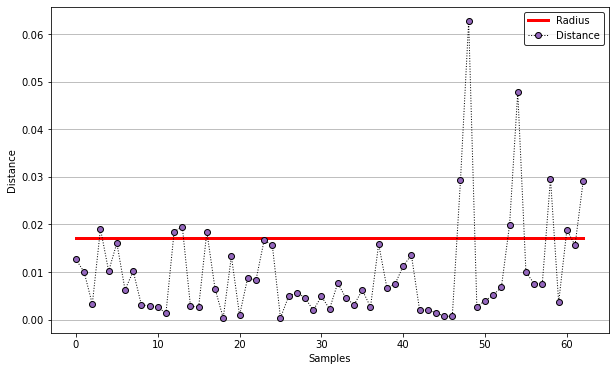

CPU times: total: 1.06 s
Wall time: 497 ms


In [6]:
%%time
svdd = BaseSVDD(C=param, gamma=0.01, kernel='rbf', display='on')

svdd.fit(x_tr)
pre_t = svdd.predict(x_tr)
pre_g = svdd.predict(x_tg)
pre_e = svdd.predict(x_te)
radius = svdd.radius
distance = svdd.get_distance(x_tg)
svdd.plot_distance(radius, distance)
distance = svdd.get_distance(x_te)
svdd.plot_distance(radius, distance)

alphas = svdd.alpha
Param = svdd.C

In [7]:
m, n = x_tr.shape
SV = []
NSV = []
for i in range(m):
  if alphas[i] > 0 and alphas[i] <= Param[0]:
    SV.append(list(X_train[i, :]))
  else:
    NSV.append(list(X_train[i, :]))

sv = np.array(SV)
nsv = np.array(NSV)

vae.fit(sv, epochs=50, batch_size=64, validation_data=(x_test, None))

Epoch 1/50
1/1 [==============================] - 1s 919ms/step - loss: 24.6782 - val_loss: 23.1768
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 32.3526 - val_loss: 23.9388
Epoch 3/50
1/1 [==============================] - 1s 720ms/step - loss: 26.3325 - val_loss: 22.7905
Epoch 4/50
1/1 [==============================] - 1s 782ms/step - loss: 22.2978 - val_loss: 23.1241
Epoch 5/50
1/1 [==============================] - 1s 646ms/step - loss: 22.9431 - val_loss: 25.7350
Epoch 6/50
1/1 [==============================] - 1s 701ms/step - loss: 22.1438 - val_loss: 23.1751
Epoch 7/50
1/1 [==============================] - 1s 712ms/step - loss: 21.6348 - val_loss: 23.4207
Epoch 8/50
1/1 [==============================] - 1s 652ms/step - loss: 22.0334 - val_loss: 22.5273
Epoch 9/50
1/1 [==============================] - 1s 756ms/step - loss: 22.3115 - val_loss: 22.6375
Epoch 10/50
1/1 [==============================] - 1s 743ms/step - loss: 22.8471 - val_loss: 22.8666
Ep

In [8]:
x_tr, _, _ = encoder.predict(X_train)
x_tg, _, _ = encoder.predict(X_test_good)
x_te, _, _ = encoder.predict(X_test_error)

2/2 [==============================] - 0s 44ms/step




*** Fitting of the SVDD model is completed. ***

running time         = 0.0384 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 209
number of features   = 20
number of SVs        = 209
ratio of SVs         = 100.0000 %
accuracy             = 64.5933 %




*** Prediction of the provided data is completed. ***

running time         = 0.0028 seconds
number of samples    = 209
number of alarm      = 74




*** Prediction of the provided data is completed. ***

running time         = 0.0014 seconds
number of samples    = 20
number of alarm      = 10




*** Prediction of the provided data is completed. ***

running time         = 0.0010 seconds
number of samples    = 63
number of alarm      = 26




C:\Users\Shuta Tsuchio\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


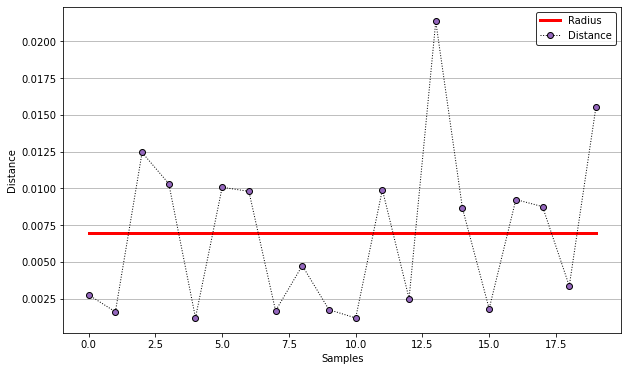

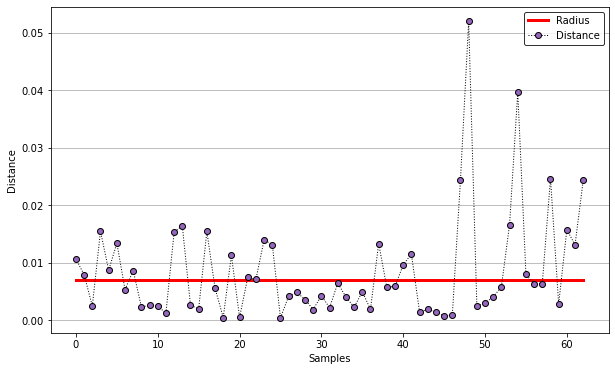

CPU times: total: 859 ms
Wall time: 327 ms


In [9]:
%%time
svdd = BaseSVDD(C=2**(-6), gamma=0.01, kernel='rbf', display='on')

svdd.fit(x_tr)
pre_t = svdd.predict(x_tr)
pre_g = svdd.predict(x_tg)
pre_e = svdd.predict(x_te)
radius = svdd.radius
distance = svdd.get_distance(x_tg)
svdd.plot_distance(radius, distance)
distance = svdd.get_distance(x_te)
svdd.plot_distance(radius, distance)

alphas = svdd.alpha
Param = svdd.C